# Intro 

In this notebook, we will learn how to use hail functions to annotate the Expression Modifier Score (EMS) for a given list of variant-gene pairs (vgs).

Most of the work in this notebook is performed in google cloud using hail. Specifically, we ran

`hailctl dataproc start qbwcluster-mpl -w 8 --pkgs matplotlib,seaborn,sklearn`

Followed by

`hailctl dataproc connect qbwcluster-mpl notebook`

To start the jupyter notebook in the google cloud cluster.

(For more info on setting up the cluster and notebook, please visit the relevant pages: [hail](https://hail.is/index.html) and the [hail dataproc](https://github.com/Nealelab/cloudtools/blob/master/README.md))

After building the cluster and starting this notebook, the first step is to import hail and relevant tools:

In [1]:
#import and initialize hail 
import hail as hl
import hail.expr.aggregators as agg
hl.init(default_reference='GRCh38')

#import other useful tools
import time as tm
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns

Running on Apache Spark version 2.4.5
SparkUI available at http://qbwcluster-mpl-m.c.encode-uk-biobank.internal:4041
Welcome to
     __  __     <>__
    / /_/ /__  __/ /
   / __  / _ `/ / /
  /_/ /_/\_,_/_/_/   version 0.2.26-2dcc3d963867
LOGGING: writing to /home/hail/hail-20200914-2112-0.2.26-2dcc3d963867.log


Now assuming that we have the environment built, first, let's start taking a look at the EMS in Whole Blood by reading it as a hail table:

In [2]:
tissue_name = "Whole_Blood"
ems = hl.read_table("gs://expression-modifier-score/public/ht/ems_{0}.ht".format(tissue_name))
ems.head(5).show() #show the first 5 entries

v,g,rf_score_raw,ems,ems_normalized
str,str,float64,float64,float64
"""chr10_100000235_C_T_b38""","""ENSG00000014919.12""",3.90e-02,1.78e-06,1.47e-01
"""chr10_100000235_C_T_b38""","""ENSG00000023839.10""",4.48e-02,2.42e-06,1.99e-01
"""chr10_100000235_C_T_b38""","""ENSG00000055950.16""",1.77e-02,5.31e-07,4.37e-02
"""chr10_100000235_C_T_b38""","""ENSG00000075290.7""",2.07e-02,5.08e-07,4.19e-02
"""chr10_100000235_C_T_b38""","""ENSG00000075826.16""",1.84e-02,5.31e-07,4.37e-02


The `v` column shows the variant (in hg38), 

the `g` column shows the gene, 

the `rf_score_raw` is the raw output score from the random forest model used in building the EMS (ranging from 0 to 1), 

the `ems` is the EMS, corresponding to the estimated probability of the variant-gene pairs being a putative causal eQTL, and

the `ems_normalized` is the EMS divided by the probability that a random variant-gene pair being a putative causal eQTL.

Since EMS is defined for all the variant-gene pairs in GTEx, the table is quite large:

In [3]:
ems.count() #counts the number of rows

149429947

As this number is quite large, in this tutorial we will cut down and focus on the first 100,000 entries:

In [4]:
ems = ems.head(100000) #cut down to the first 100,000 entries

### EMS in different tissues

We can simply change the tissue name to get the EMS for a different tissue:

In [5]:
tissue_name = "Muscle_Skeletal"
ems_muscle = hl.read_table("gs://expression-modifier-score/public/ht/ems_{0}.ht".format(tissue_name))
ems_muscle.head(5).show() #show the first 5 entries for the EMS in skeletal muscle

v,g,rf_score_raw,ems,ems_normalized
str,str,float64,float64,float64
"""chr10_100000235_C_T_b38""","""ENSG00000014919.12""",2.57e-02,9.74e-07,8.97e-02
"""chr10_100000235_C_T_b38""","""ENSG00000023839.10""",5.29e-02,2.22e-06,2.05e-01
"""chr10_100000235_C_T_b38""","""ENSG00000055950.16""",7.14e-03,3.53e-07,3.25e-02
"""chr10_100000235_C_T_b38""","""ENSG00000075290.7""",1.00e-02,4.27e-07,3.93e-02
"""chr10_100000235_C_T_b38""","""ENSG00000075826.16""",8.57e-03,4.12e-07,3.80e-02


# Filtering
Here we will show an example of filtering the EMS table with specific condition of interest. 

One might be interested in only the variants that are more likely to be putative causal than by chance. 
Then we can filter the table with the value of `ems_normalized`:

In [6]:
ems_sub = ems.filter(ems.ems_normalized>1)
ems_sub.head(5).show()

v,g,rf_score_raw,ems,ems_normalized
str,str,float64,float64,float64
"""chr10_100000235_C_T_b38""","""ENSG00000107554.16""",5.91e-01,1.21e-04,9.93e+00
"""chr10_100000943_G_A_b38""","""ENSG00000107554.16""",4.25e-01,4.71e-05,3.88e+00
"""chr10_100000979_T_C_b38""","""ENSG00000107554.16""",6.52e-01,2.27e-04,1.87e+01
"""chr10_100002012_T_C_b38""","""ENSG00000107554.16""",6.38e-01,1.80e-04,1.49e+01
"""chr10_100002038_G_A_b38""","""ENSG00000107554.16""",4.85e-01,8.12e-05,6.69e+00


In [7]:
print (ems.count())
print (ems_sub.count())

100000
8548


Only ~=8% of the vgs have `ems_normalized`>1.

# Aggregation
One might be interested in only the variants. We can aggregate the table to get the maximum EMS for a variant:

In [8]:
ems_max = ems.group_by("v").aggregate(max_ems = hl.agg.max(ems.ems))
ems_max.head(5).show()

2020-09-14 21:12:54 Hail: INFO: Ordering unsorted dataset with network shuffle


v,max_ems
str,float64
"""chr10_100000235_C_T_b38""",1.21e-04
"""chr10_100000943_G_A_b38""",4.71e-05
"""chr10_100000979_T_C_b38""",2.27e-04
"""chr10_100002012_T_C_b38""",1.80e-04
"""chr10_100002038_G_A_b38""",8.12e-05


# Annotating EMS for a set of vgs
Here we will show an example of annotating EMS for a set of variant and genes of interest.


Let's assume we have a `tsv` file with 10 rows of variant and genes, with the TSS distance annotated. 

We can read that as a hail table by `import_table`:



In [9]:
df = hl.import_table("gs://qingbowang/vg_head10000_example.tsv", impute=True)
df.head(5).show()

2020-09-14 21:12:55 Hail: INFO: Reading table to impute column types
2020-09-14 21:12:56 Hail: INFO: Finished type imputation
  Loading column 'v' as type 'str' (imputed)
  Loading column 'g' as type 'str' (imputed)
  Loading column 'tss_distance' as type 'int32' (imputed)


v,g,tss_distance
str,str,int32
"""chr10_100000235_C_T_b38""","""ENSG00000107554.16""",-9684
"""chr10_100000943_G_A_b38""","""ENSG00000055950.16""",-986423
"""chr10_100000943_G_A_b38""","""ENSG00000107816.17""",-995675
"""chr10_100000943_G_A_b38""","""ENSG00000119906.11""",-911797
"""chr10_100000979_T_C_b38""","""ENSG00000055950.16""",-986387


We can annotate the EMS using hail language. Below are two examples of doing so:

In [10]:
#make sure that two tables of interest have the same keys
df = df.key_by("v", "g")
print (ems.key)
print (df.key)

#1. simply `annotate` the column of interest
df1 = df.annotate(ems = ems[df.key].ems)
df1.head(5).show()

#2. use `join` to annotate all the columns together
df2 = df.join(ems, how="left")
df2.head(5).show()


<StructExpression of type struct{v: str, g: str}>
<StructExpression of type struct{v: str, g: str}>


2020-09-14 21:12:57 Hail: INFO: Coerced sorted dataset


v,g,tss_distance,ems
str,str,int32,float64
"""chr10_100000235_C_T_b38""","""ENSG00000107554.16""",-9684,1.21e-04
"""chr10_100000943_G_A_b38""","""ENSG00000055950.16""",-986423,2.74e-07
"""chr10_100000943_G_A_b38""","""ENSG00000107816.17""",-995675,2.74e-07
"""chr10_100000943_G_A_b38""","""ENSG00000119906.11""",-911797,2.74e-07
"""chr10_100000979_T_C_b38""","""ENSG00000055950.16""",-986387,5.16e-07


2020-09-14 21:12:59 Hail: INFO: Coerced sorted dataset


v,g,tss_distance,rf_score_raw,ems,ems_normalized
str,str,int32,float64,float64,float64
"""chr10_100000235_C_T_b38""","""ENSG00000107554.16""",-9684,5.91e-01,1.21e-04,9.93e+00
"""chr10_100000943_G_A_b38""","""ENSG00000055950.16""",-986423,8.61e-03,2.74e-07,2.26e-02
"""chr10_100000943_G_A_b38""","""ENSG00000107816.17""",-995675,8.61e-03,2.74e-07,2.26e-02
"""chr10_100000943_G_A_b38""","""ENSG00000119906.11""",-911797,9.38e-03,2.74e-07,2.26e-02
"""chr10_100000979_T_C_b38""","""ENSG00000055950.16""",-986387,1.87e-02,5.16e-07,4.25e-02


# Aggregation and Enrichment analysis

In our manuscript, we quantified the enrichment of different genomic annotations in different EMS bins.

As an example to replicate such analysis, here, we will investigate the relationship between distance to TSS and EMS.

First, let's bin EMS and TSS in different windows:

In [11]:
df2 = df2.filter(hl.is_defined(df2.ems))#remove small number of NAs
df2 = df2.annotate(tss_distance_bin = hl.case()
                                      .when(df2.tss_distance <10**4, 1) 
                                      .default(2), 
                   ems_normalized_bin = hl.case()
                                       .when(df2.ems_normalized>10, 1)
                                       .default(2) )

summary = df2.group_by("tss_distance_bin", "ems_normalized_bin").aggregate(n = hl.agg.count())
summary.show()

2020-09-14 21:13:00 Hail: INFO: Coerced sorted dataset
2020-09-14 21:13:02 Hail: INFO: Coerced sorted dataset
2020-09-14 21:13:02 Hail: INFO: Coerced dataset with out-of-order partitions.


tss_distance_bin,ems_normalized_bin,n
int32,int32,int64
1,1,146
1,2,5389
2,1,78
2,2,4387


We can make small pandas dataframe to compare the distribution of distance to TSS for vgs with high vs low EMS:

In [12]:
summary = summary.to_pandas()
summary = pd.pivot_table(summary, values='n', index="tss_distance_bin",columns="ems_normalized_bin")
summary.index.names = ["tss_distance"]
summary.columns.names = ["ems_normalized"]
summary.index = ["<10000", ">10000"]
summary.columns = [">10", "<10"]
summary

2020-09-14 21:13:02 Hail: INFO: Coerced sorted dataset
2020-09-14 21:13:03 Hail: INFO: Coerced sorted dataset
2020-09-14 21:13:03 Hail: INFO: Coerced dataset with out-of-order partitions.


,>10,<10
<10000,146,5389
>10000,78,4387


And not surprisingly, variants with distance to TSS <10kb are enriched in high (>10x the random) EMS variants:

findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.


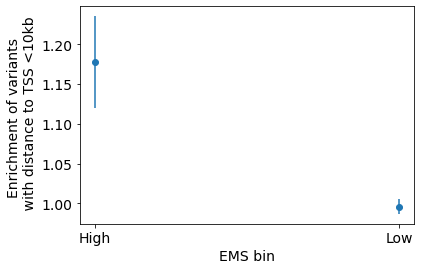

In [13]:
rd = summary.iloc[0,:].sum() / summary.sum().sum() #prob(close to TSS) for a random variant
enr = summary.iloc[0,:] / summary.sum(axis=0) #prob(close to TSS | high or low EMS)
err = np.sqrt(enr*(1-enr) / summary.sum(axis=0)) #sem
enr = enr/rd #divide by the random to get an enrichment
err = err/rd #divide by the random, for an estimate of the error of the enrichment

plt.rcParams.update({'font.size': 14})
plt.rcParams['font.sans-serif'] = "Arial"
plt.rcParams['font.family'] = "sans-serif"
plt.errorbar([0,1], enr, err, fmt="o")
plt.xlabel("EMS bin")
plt.ylabel("Enrichment of variants \n with distance to TSS <10kb")
plt.xticks([0,1],["High","Low"])
plt.show()

# End notes

This tutorial explained basic properties of EMS, how to annotate EMS to a set of variant-gene pairs, and an example of enrichment analysis using EMS, in a cloud environment. 

For users who prefer file formats other than hail table, we have also prepared `tsv` files for a subset of variant-gene pairs (those with `ems_normalized>100`), and the corresponding tutorial is available at `tutorial_local.ipynb`.

